In [1]:
# 如何知道有多少數據 Shift + Enter , Ctrl + Enter
from keras import datasets
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
#print(dir(datasets))

Using CNTK backend


GPU


In [2]:
from keras.datasets import mnist
#print(dir(mnist))

In [3]:
# 數據是28 * 28 = 784
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

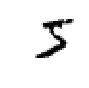

In [4]:
# 畫一張
plt.figure(figsize=(1,1))
plt.imshow(X_train[0], cmap='gray_r')
plt.axis('off')
plt.show()

In [5]:
# data pre-processing MLP , not for CNN
X_train, X_test = X_train.astype(np.float32).reshape(60000, 28, 28, 1)/255.0, \
                  X_test.astype(np.float32).reshape(10000, 28, 28, 1)/255.0
# one_hot encoding
y_train_oh, y_test_oh = to_categorical(y_train), to_categorical(y_test) 

print(X_train.shape , X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [16]:
# build model
# keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', activation=None)
# filters 幾種新的圖框 來描述圖片的邊界效果
# kernel_size 掃描整個原圖過程中要使用的計算大小，搭配kernel_weight取出邊界
# strides 確保新的圖框 大小是否跟原圖一樣大 因素之一，掃描的每一次往左右下上的推進大小
# padding 確保新的圖框 大小是否跟原圖一樣大 因素之二，掃描的要不要針對邊框加上多一格的數據
# input_shape 因為針對圖片進行作業 所以要指定row * col * RGB <--"image_data_format": "channels_last"
# https://i.stack.imgur.com/9OZKF.gif 看圖
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, AveragePooling2D
from keras import optimizers
model = Sequential()

model.add( Conv2D(filters=8, kernel_size=(5,5), strides=(1, 1), 
                  padding='same', activation='relu', input_shape=(28, 28, 1)  ))
model.add(AveragePooling2D(pool_size=(5, 5), strides=(2, 2)))
model.add( Conv2D(filters=16, kernel_size=(5,5), strides=(1, 1), 
                  padding='same', activation='relu' )) #(8 * (3, 3) + 1 ) * 16 = 1168
model.add(AveragePooling2D(pool_size=(5, 5), strides=(2, 2)))
model.add( Flatten()) # 將上述的新產生的filters=四種圖框 攤平
#model.add( Dense(units=1000, activation='relu' ) )
#model.add( Dense(units=500, activation='relu') )
model.add( Dense(units=10, activation='softmax') )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 28, 28, 8)         208       
_________________________________________________________________
average_pooling2d_15 (Averag (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 12, 12, 16)        3216      
_________________________________________________________________
average_pooling2d_16 (Averag (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
Total params: 5,994
Trainable params: 5,994
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train model 
# ValueError: Error when checking target: expected dense_3 to have 2 dimensions
# but got array with shape (60000, 10, 2, 2)
# ValueError: Error when checking target: expected dense_6 to have shape (10,) but got array with shape (1,)
# 54000/54000 [==============================] - 89s 2ms/step - 
# loss: 0.3113 - acc: 0.9134 - val_loss: 0.1181 - val_acc: 0.9660

model.compile(optimizer=optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'] )
history = model.fit(X_train, y_train_oh, validation_split=0.1, epochs=10, verbose=1)


In [ ]:
#keras 2.2.* : acc 
#keras 2.3.* : accuracy

In [ ]:
# Plot
plt.title('Accuracy of Keras')
plt.plot(history.history['acc'], color='blue')
plt.plot(history.history['val_acc'], color='red')
plt.grid()
plt.show()


plt.title('Loss of Keras')
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='red')
plt.grid()
plt.show()

In [ ]:
# evaluate model 
print(model.evaluate(X_train, y_train_oh), model.evaluate(X_test, y_test_oh) )
# predict model 
y_pred = model.predict(X_test)

In [ ]:
# top 10 
# 請你找一下那些數字是錯誤 slicing 
index_error = np.argmax(y_pred, axis=1) != np.argmax(y_test_oh, axis=1)

X_error      =  X_test[ index_error ]
y_error      =  y_test_oh[ index_error ]
y_error_pred =  y_pred[ index_error ]

print('Total error amount is {}'.format(X_error.shape[0]))

# Plot for top 10 [:10]
for i in range(10):
    plt.figure(figsize=(1,1))
    plt.title('GT:{} --> Pred:{}'.format(np.argmax(y_error[i]), np.argmax(y_error_pred[i])) )
    plt.imshow(X_error[i].reshape(28,28), cmap='gray' )
    plt.axis('off')
    plt.show()

In [ ]:
# filter = N  filters 幾種新的圖框 來描述圖片的邊界效果
for L in model.layers:
    print(L)  

In [ ]:
# filter = 4 --> weights
model.layers[0].get_weights()[0].shape # 3, 3, 1, 25
# 3,3 = kernel_size
# 1   = channel
# 25   = filter nunber

In [ ]:
# 我們有四種圖樣
filter_0_weight = model.layers[0].get_weights()[0][..., 0] # 0, 1, 2, 3
# (3, 3, 1) print(filter_0_weight.shape)
img = X_train[0].reshape(28, 28)
plt.figure(figsize=(2/3,2/3))
plt.imshow(img, cmap='gray_r')
plt.axis('off')
plt.title('Source Image')
plt.show()

# 這部分就是針對kernel_weight 跟圖片進行計算 然後產生新的圖框
# https://i.stack.imgur.com/9OZKF.gif 看圖
kernel = filter_0_weight.reshape(3, 3)
height, width = img.shape[0]-2, img.shape[1]-2 # 就是kernel.shape去計算出來  e.g 3*3 => (3-1), (3-1) => -2, -2
conv = np.zeros((height, width))
for ii in range(height):
    for jj in range(width):
        val = np.sum(kernel * img[ii:ii+3, jj:jj+3]) # kernel.shape去計算出來 e.g 3*3 => +3 , +3
        conv[ii, jj] = val # 就是將source image * kernel_weight 數據寫回去新圖框
plt.figure(figsize=(2/3, 2/3))
plt.title('Convolution Image')
plt.imshow(conv, cmap='gray_r')
plt.axis('off')
plt.show()


In [ ]:
# 以下是優化程式碼撰寫 #

In [ ]:
def kernel(kernel, img):
    # 這部分就是針對kernel_weight 跟圖片進行計算 然後產生新的圖框
    # https://i.stack.imgur.com/9OZKF.gif 看圖
    
    height, width = img.shape[0]-2, img.shape[1]-2 # 就是kernel.shape去計算出來  e.g 3*3 => (3-1), (3-1) => -2, -2
    conv = np.zeros((height, width))
    for ii in range(height):
        for jj in range(width):
            val = np.sum(kernel * img[ii:ii+3, jj:jj+3]) # kernel.shape去計算出來 e.g 3*3 => +3 , +3
            conv[ii, jj] = val # 就是將source image * kernel_weight 數據寫回去新圖框
    return conv


In [ ]:
model.layers[0].get_weights()[0][..., 0].shape

In [ ]:
# 單一種圖樣 plt.subplots
kernels = model.layers[0].get_weights()[0]
img = X_train[0].reshape(28, 28)
img_cnn = kernel(kernels[..., 0], img)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Source vs CNN')
ax1.imshow(img, cmap='gray_r')
ax1.axis('off')
ax2.imshow(img_cnn, cmap='gray_r')
ax2.axis('off')
plt.show()

In [ ]:
model.layers[0].get_weights()[0].shape[-1] # 總共次數

In [ ]:
# 我們有四種圖樣 plt.subplots
kernels = model.layers[0].get_weights()[0]
img = X_train[0].reshape(28, 28)
for k in range(model.layers[0].get_weights()[0].shape[-1]): 
    img_cnn = kernel(kernels[..., k], img)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4/3,4/3))
    fig.suptitle('Source vs CNN {}'.format(k) )
    ax1.imshow(img, cmap='gray_r')
    ax1.axis('off')    
    ax2.imshow(img_cnn, cmap='gray_r')
    ax2.axis('off')
    plt.show()

In [ ]:
import os
print(os.getcwd())